# Projeto Interpretabilidade de modelos 

Grupo:
- Lucas dos Reis Silva
- Gabriel Homci




In [ ]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from imblearn.metrics import geometric_mean_score
from rich import print as rprint
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier

/Users/lucasreis/Documents/xAI-football-bet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Conjunto de Dados

In [2]:
# Load all CSV files
pasta = 'dataset'
arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]

dfs = []
for arquivo in arquivos:
    caminho_completo = os.path.join(pasta, arquivo)
    df = pd.read_csv(caminho_completo)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Select and rename columns
column_map = {
    "Date": "match_date",
    "HomeTeam": "home_team",
    "AwayTeam": "away_team",
    "FTHG": "full_time_home_goals",
    "FTAG": "full_time_away_goals",
    "FTR": "full_time_result",
    "HS": "home_shots",
    "AS": "away_shots",
    "HST": "home_shots_on_target",
    "AST": "away_shots_on_target",
    "HC": "home_corners",
    "AC": "away_corners",
    "B365H": "b365_home",      
    "B365D": "b365_draw",      
    "B365A": "b365_away",
}

df = df[column_map.keys()].rename(columns=column_map)

# Encode teams
teams = sorted(df["home_team"].unique())
teams_map = {team: i+1 for i, team in enumerate(teams)}
teams_map_reverse = {i+1: team for i, team in enumerate(teams)}

# Encode results and dates
df['full_time_result'] = df['full_time_result'].map({'A': 0, 'D': 1, 'H': 2})
df['home_team'] = df['home_team'].map(teams_map)
df['away_team'] = df['away_team'].map(teams_map)
df['match_date'] = pd.to_datetime(df['match_date'], dayfirst=True)
df = df.sort_values('match_date').reset_index(drop=True)

In [3]:
df

,match_date,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_corners,away_corners,b365_home,b365_draw,b365_away
0,2021-08-13,4,1,2,0,2,8,22,3,4,2,5,4.00,3.40,1.95
1,2021-08-14,17,12,5,1,2,16,10,8,3,5,4,1.53,4.50,5.75
2,2021-08-14,6,5,1,2,0,14,14,3,8,7,6,3.10,3.10,2.45
3,2021-08-14,7,8,3,0,2,13,4,6,1,5,2,1.25,5.75,13.00
4,2021-08-14,9,22,3,1,2,14,6,6,3,6,8,1.90,3.50,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,2025-05-25,11,25,1,3,0,14,10,4,6,4,0,3.00,3.80,2.20
1516,2025-05-25,10,16,0,2,0,13,20,3,5,1,6,5.00,4.20,1.60
1517,2025-05-25,3,13,2,0,2,20,3,7,0,6,1,1.33,5.25,8.50
1518,2025-05-25,14,8,1,1,1,14,8,3,5,11,0,1.40,6.00,5.75


In [4]:
def calculate_ewma(values, alpha=0.3):
    """Calculate exponentially weighted moving average"""
    weights = np.array([alpha * (1 - alpha)**i for i in range(len(values))])
    weights = weights / weights.sum()
    return np.sum(values * weights)

In [5]:
def extract_metrics_from_games(games_df, is_home=True):
    """
    Extract metrics from a list of games.
    
    Args:
        games_df: DataFrame of games to extract from
        is_home: If True, extract HOME team perspective; if False, AWAY team perspective
    
    Returns:
        Dict with goals_for, goals_against, shots, shots_target, corners
        or None if no games
    """
    
    if len(games_df) == 0:
        return None
    
    if is_home:
        # Extract metrics from HOME perspective
        goals_for = games_df['full_time_home_goals'].values
        goals_against = games_df['full_time_away_goals'].values
        shots = games_df['home_shots'].values
        shots_target = games_df['home_shots_on_target'].values
        corners = games_df['home_corners'].values
    else:
        # Extract metrics from AWAY perspective
        goals_for = games_df['full_time_away_goals'].values
        goals_against = games_df['full_time_home_goals'].values
        shots = games_df['away_shots'].values
        shots_target = games_df['away_shots_on_target'].values
        corners = games_df['away_corners'].values
    
    return {
        'goals_for': goals_for,
        'goals_against': goals_against,
        'shots': shots,
        'shots_target': shots_target,
        'corners': corners,
    }
    
def extract_overall_metrics_from_mixed_games(games_df, team_id):
    """
    Extract metrics from mixed games (team played both home and away).
    Converts all to the team's perspective.
    """
    
    if len(games_df) == 0:
        return None
    
    goals_for = []
    goals_against = []
    shots = []
    shots_target = []
    corners = []
    
    for _, game in games_df.iterrows():
        if game['home_team'] == team_id:
            # Team played at home
            goals_for.append(game['full_time_home_goals'])
            goals_against.append(game['full_time_away_goals'])
            shots.append(game['home_shots'])
            shots_target.append(game['home_shots_on_target'])
            corners.append(game['home_corners'])
        else:
            # Team played away
            goals_for.append(game['full_time_away_goals'])
            goals_against.append(game['full_time_home_goals'])
            shots.append(game['away_shots'])
            shots_target.append(game['away_shots_on_target'])
            corners.append(game['away_corners'])
    
    return {
        'goals_for': np.array(goals_for),
        'goals_against': np.array(goals_against),
        'shots': np.array(shots),
        'shots_target': np.array(shots_target),
        'corners': np.array(corners),
    }

In [6]:
dataset = []
window_size = 10
min_games_threshold = 1 
alpha = 0.3

for idx, row in df.iterrows():

    date = row["match_date"]
    home_team = row["home_team"]
    away_team = row["away_team"]
    result = row["full_time_result"]
    b365_home = row["b365_home"]
    b365_draw = row["b365_draw"]
    b365_away = row["b365_away"]
    
    
    # Get historical games (HOME team perspective)

    home_home_games = df[(df["home_team"] == home_team) & (df["match_date"] < date)].tail(window_size)
    home_overall_games = df[((df["home_team"] == home_team) | (df["away_team"] == home_team)) & (df["match_date"] < date)].tail(window_size)
    
    
    if len(home_home_games) >= 1:
        home_metrics = extract_metrics_from_games(home_home_games, is_home=True)
    else:
        home_metrics = extract_overall_metrics_from_mixed_games(home_overall_games, home_team)
    
    home_overall_metrics = extract_overall_metrics_from_mixed_games(home_overall_games, home_team)
    
    # Get historical games (AWAY team perspective)

    away_away_games = df[(df["away_team"] == away_team) & (df["match_date"] < date)].tail(window_size)
    away_overall_games = df[((df["home_team"] == away_team) | (df["away_team"] == away_team)) & (df["match_date"] < date)].tail(window_size)
    
    if len(away_away_games) >= 1:
        away_metrics = extract_metrics_from_games(away_away_games, is_home=False)
    else:
        away_metrics = extract_overall_metrics_from_mixed_games(away_overall_games, away_team)
    
    away_overall_metrics = extract_overall_metrics_from_mixed_games(away_overall_games, away_team)
    
    # Skip if insufficient data
    if (home_metrics is None or away_metrics is None or 
        home_overall_metrics is None or away_overall_metrics is None):
        continue
    
    # Build feature dictionary 

    features = {'date': date, 'result': result, "b365_home": b365_home, "b365_draw": b365_draw, "b365_away": b365_away}
    

    # HOME TEAM - Context-specific (home games)

    features['home_goals_for_ewma'] = calculate_ewma(home_metrics['goals_for'], alpha)
    features['home_goals_against_ewma'] = calculate_ewma(home_metrics['goals_against'], alpha)
    features['home_shots_ewma'] = calculate_ewma(home_metrics['shots'], alpha)
    features['home_shots_target_ewma'] = calculate_ewma(home_metrics['shots_target'], alpha)
    

    # AWAY TEAM - Context-specific (away games)

    features['away_goals_for_ewma'] = calculate_ewma(away_metrics['goals_for'], alpha)
    features['away_goals_against_ewma'] = calculate_ewma(away_metrics['goals_against'], alpha)
    features['away_shots_ewma'] = calculate_ewma(away_metrics['shots'], alpha)
    features['away_shots_target_ewma'] = calculate_ewma(away_metrics['shots_target'], alpha)
    

    # HOME TEAM - Overall form (all games mixed)

    features['home_overall_goals_for_ewma'] = calculate_ewma(home_overall_metrics['goals_for'], alpha)
    features['home_overall_goals_against_ewma'] = calculate_ewma(home_overall_metrics['goals_against'], alpha)
    features['home_overall_shots_ewma'] = calculate_ewma(home_overall_metrics['shots'], alpha)
    features['home_overall_shots_target_ewma'] = calculate_ewma(home_overall_metrics['shots_target'], alpha)
    

    # AWAY TEAM - Overall form (all games mixed)

    features['away_overall_goals_for_ewma'] = calculate_ewma(away_overall_metrics['goals_for'], alpha)
    features['away_overall_goals_against_ewma'] = calculate_ewma(away_overall_metrics['goals_against'], alpha)
    features['away_overall_shots_ewma'] = calculate_ewma(away_overall_metrics['shots'], alpha)
    features['away_overall_shots_target_ewma'] = calculate_ewma(away_overall_metrics['shots_target'], alpha)
    
    # Derived Features 
    
    # Goal differences
    features['home_goal_diff_ewma'] = features['home_goals_for_ewma'] - features['home_goals_against_ewma']
    features['away_goal_diff_ewma'] = features['away_goals_for_ewma'] - features['away_goals_against_ewma']
    features['home_overall_goal_diff_ewma'] = features['home_overall_goals_for_ewma'] - features['home_overall_goals_against_ewma']
    features['away_overall_goal_diff_ewma'] = features['away_overall_goals_for_ewma'] - features['away_overall_goals_against_ewma']
    
    # Shot accuracy
    features['home_shot_acc_ewma'] = features['home_shots_target_ewma'] / (features['home_shots_ewma'] + 0.001)
    features['away_shot_acc_ewma'] = features['away_shots_target_ewma'] / (features['away_shots_ewma'] + 0.001)
    features['home_overall_shot_acc_ewma'] = features['home_overall_shots_target_ewma'] / (features['home_overall_shots_ewma'] + 0.001)
    features['away_overall_shot_acc_ewma'] = features['away_overall_shots_target_ewma'] / (features['away_overall_shots_ewma'] + 0.001)
    
    # Win/Loss/Draw rates 
    home_wins = (home_metrics['goals_for'] - home_metrics['goals_against'] > 0).astype(int)
    home_draws = (home_metrics['goals_for'] - home_metrics['goals_against'] == 0).astype(int)
    home_losses = (home_metrics['goals_for'] - home_metrics['goals_against'] < 0).astype(int)
    
    away_wins = (away_metrics['goals_for'] - away_metrics['goals_against'] > 0).astype(int)
    away_draws = (away_metrics['goals_for'] - away_metrics['goals_against'] == 0).astype(int)
    away_losses = (away_metrics['goals_for'] - away_metrics['goals_against'] < 0).astype(int)
    
    features['home_win_rate_ewma'] = calculate_ewma(home_wins, alpha)
    features['home_draw_rate_ewma'] = calculate_ewma(home_draws, alpha)
    features['home_loss_rate_ewma'] = calculate_ewma(home_losses, alpha)
    
    features['away_win_rate_ewma'] = calculate_ewma(away_wins, alpha)
    features['away_draw_rate_ewma'] = calculate_ewma(away_draws, alpha)
    features['away_loss_rate_ewma'] = calculate_ewma(away_losses, alpha)
    
    # Overall win/loss/draw rates
    home_overall_wins = (home_overall_metrics['goals_for'] - home_overall_metrics['goals_against'] > 0).astype(int)
    away_overall_wins = (away_overall_metrics['goals_for'] - away_overall_metrics['goals_against'] > 0).astype(int)
    
    features['home_overall_win_rate_ewma'] = calculate_ewma(home_overall_wins, alpha)
    features['away_overall_win_rate_ewma'] = calculate_ewma(away_overall_wins, alpha)
    
    # Matchup Features

    features['goal_diff_matchup'] = features['home_goal_diff_ewma'] - features['away_goal_diff_ewma']
    features['shots_matchup'] = features['home_shots_ewma'] - features['away_shots_ewma']
    features['shot_acc_matchup'] = features['home_shot_acc_ewma'] - features['away_shot_acc_ewma']
    features['win_rate_diff'] = features['home_win_rate_ewma'] - features['away_win_rate_ewma']
    features['draw_rate_diff'] = features['home_draw_rate_ewma'] - features['away_draw_rate_ewma']
    features['overall_goal_diff_matchup'] = features['home_overall_goal_diff_ewma'] - features['away_overall_goal_diff_ewma']
    features['overall_shots_matchup'] = features['home_overall_shots_ewma'] - features['away_overall_shots_ewma']
    features['overall_win_rate_diff'] = features['home_overall_win_rate_ewma'] - features['away_overall_win_rate_ewma']
    
    dataset.append(features)

df_model = pd.DataFrame(dataset)
df_model

,date,result,b365_home,b365_draw,b365_away,home_goals_for_ewma,home_goals_against_ewma,home_shots_ewma,home_shots_target_ewma,away_goals_for_ewma,...,home_overall_win_rate_ewma,away_overall_win_rate_ewma,goal_diff_matchup,shots_matchup,shot_acc_matchup,win_rate_diff,draw_rate_diff,overall_goal_diff_matchup,overall_shots_matchup,overall_win_rate_diff
0,2021-08-21,2,1.70,3.50,5.75,2.000000,1.000000,14.000000,8.000000,3.000000,...,1.000000,1.000000,0.000000,1.000000,0.032968,0.000000,0.000000,0.000000,1.000000,0.000000
1,2021-08-21,2,1.08,11.00,26.00,0.000000,1.000000,18.000000,4.000000,0.000000,...,0.000000,0.000000,2.000000,4.000000,0.007939,0.000000,0.000000,2.000000,4.000000,0.000000
2,2021-08-21,1,2.37,3.40,3.00,1.000000,5.000000,10.000000,3.000000,3.000000,...,0.000000,1.000000,-6.000000,-4.000000,-0.128571,-1.000000,0.000000,-6.000000,-4.000000,-1.000000
3,2021-08-21,2,1.80,3.75,4.33,2.000000,3.000000,11.000000,2.000000,2.000000,...,0.000000,0.000000,1.000000,-6.000000,0.005341,0.000000,0.000000,1.000000,-6.000000,0.000000
4,2021-08-21,2,1.18,7.50,13.00,3.000000,0.000000,19.000000,8.000000,1.000000,...,1.000000,0.000000,4.000000,5.000000,0.206760,1.000000,0.000000,4.000000,5.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2025-05-25,0,3.00,3.80,2.20,0.656285,2.808348,9.389872,3.741591,0.993934,...,0.151273,0.017797,-1.726077,-4.681782,0.165130,-0.179198,-0.203160,-0.507467,1.304194,0.133476
1500,2025-05-25,0,5.00,4.20,1.60,1.062172,1.142360,13.944922,4.894608,1.840427,...,0.370774,0.351487,-0.593688,-0.178361,-0.079135,-0.255810,0.486943,-0.466776,-3.665623,0.019288
1501,2025-05-25,2,1.33,5.25,8.50,1.103899,0.492576,16.484611,5.674074,0.903136,...,0.099548,0.037882,2.043327,9.999150,0.056286,0.241529,0.288635,1.351795,9.527202,0.061666
1502,2025-05-25,1,1.40,6.00,5.75,2.680224,1.118118,17.411427,5.734737,1.279823,...,0.838429,0.490249,0.678490,7.067258,-0.096803,0.211587,-0.149842,1.470807,5.455677,0.348180


In [7]:
cutoff_date = pd.to_datetime('2024-08-16')

train_df = df_model[df_model['date'] < cutoff_date].copy()
test_df = df_model[df_model['date'] >= cutoff_date].copy()

X_train = train_df.drop(columns=['result', 'date'])
y_train = train_df['result']
X_test = test_df.drop(columns=['result', 'date'])
y_test = test_df['result']

In [8]:
print(f"\n{'='*70}")
print("TRAIN/TEST SPLIT")
print(f"{'='*70}")
print(f"Training samples:     {len(X_train)}")
print(f"Test samples:         {len(X_test)}")
print(f"Features:             {X_train.shape[1]}")
print(f"Samples per feature:  {len(X_train) / X_train.shape[1]:.1f}")
print(f"\nClass distribution (train):")
for i, name in enumerate(['Away Win', 'Draw', 'Home Win']):
    count = sum(y_train == i)
    pct = count / len(y_train) * 100
    print(f"  {name:>12}  {count:>4} ({pct:>5.1f}%)")
print(f"{'='*70}")


TRAIN/TEST SPLIT
Training samples:     1125
Test samples:         379
Features:             43
Samples per feature:  26.2

Class distribution (train):
      Away Win   357 ( 31.7%)
          Draw   256 ( 22.8%)
      Home Win   512 ( 45.5%)


## Modelo

In [9]:
RANDOM_STATE = 42
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings(
    "ignore",
    message="The reported value is ignored because this `step`",
    category=UserWarning,
    module="optuna.trial._trial"
)

In [10]:
# Splitter
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
# Class weights (same as antes)
class_counts = np.bincount(y_train)
total = len(y_train)
class_weights = total / (len(class_counts) * class_counts)
sample_weights = np.array([class_weights[label] for label in y_train])

In [11]:
# Optuna Objective usando XGBClassifier
def objective(trial, X_train, y_train, sample_weights):
    
    max_depth = trial.suggest_int('max_depth', 3, 9)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 9)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    gamma = trial.suggest_float('gamma', 0.0, 0.5)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    params = {
        'max_depth': max_depth, 'min_child_weight': min_child_weight, 'learning_rate': learning_rate,
        'gamma': gamma, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda,
        'subsample': subsample, 'colsample_bytree': colsample_bytree,
        'objective': 'multi:softprob', 'num_class': 3, 'eval_metric': 'mlogloss',
        'random_state': RANDOM_STATE, 'tree_method': 'hist', 'verbosity': 0
    }

    cv_scores = []
    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        X_cv_train = X_train.iloc[train_idx]
        X_cv_val = X_train.iloc[val_idx]
        y_cv_train = y_train.iloc[train_idx]
        y_cv_val = y_train.iloc[val_idx]
        weights_cv_train = sample_weights[train_idx]

        model = XGBClassifier(**params, n_estimators=n_estimators, use_label_encoder=False)
        model.fit(X_cv_train, y_cv_train, sample_weight=weights_cv_train, verbose=False)
        y_pred = model.predict(X_cv_val)
        metric = geometric_mean_score(y_cv_val, y_pred, average='macro')
        cv_scores.append(metric)
        trial.report(metric, fold_num)
        if trial.should_prune():
            raise optuna.TrialPruned()
            
    return np.mean(cv_scores)

In [12]:

study = optuna.create_study(direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    study_name='xgboost_football_optuna')

In [13]:
n_trials = 200
study.optimize(lambda trial: objective(
    trial, X_train, y_train, sample_weights), n_trials=n_trials, show_progress_bar=True)

Best trial: 84. Best value: 0.615667: 100%|██████████| 100/100 [05:40<00:00,  3.40s/it]


In [14]:
print(f"Best Metric: {study.best_value:.4f}\n")
print("Best Parameters:")
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {key:<20} : {value:.4f}")
    else:
        print(f"  {key:<20} : {value}")

Best Metric: 0.6157

Best Parameters:
  max_depth            : 3
  min_child_weight     : 2
  learning_rate        : 0.0135
  n_estimators         : 200
  gamma                : 0.2148
  reg_alpha            : 0.8597
  reg_lambda           : 0.4340
  subsample            : 0.7411
  colsample_bytree     : 0.9118


In [17]:
# Final Training on full data
best_params = study.best_params.copy()
final_params = {
    **best_params,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}
n_estimators = final_params.pop('n_estimators')

model = XGBClassifier(**final_params, n_estimators=n_estimators, use_label_encoder=False)
model.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)

# Prediction
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')
gmean = geometric_mean_score(y_test, y_pred)

print(f"Test Accuracy:       {test_accuracy:.4f}")
print(f"Test F1 (Macro):     {test_f1_macro:.4f}")
print(f"Test F1 (Weighted):  {test_f1_weighted:.4f}")
print(f"GMean:               {gmean:.4f}")
print("-" * 70)
print("CLASSIFICATION REPORT")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

bet_amount = 2
total_profit = 0
for i in range(len(y_test)):
    true_result = y_test.iloc[i]
    pred_result = y_pred[i]
    if pred_result == true_result:
        if pred_result == 0:
            odd = X_test.iloc[i]['b365_away']
        elif pred_result == 1:
            odd = X_test.iloc[i]['b365_draw']
        else:
            odd = X_test.iloc[i]['b365_home']
        profit = bet_amount * odd - bet_amount
        total_profit += profit
    else:
        total_profit -= bet_amount
total_wagered = bet_amount * len(y_test)
profit_margin = (total_profit / total_wagered) * 100

print("="*70)
print("RESULTS")
print("="*70)
print(f"Profit:         €{total_profit:.2f}")
print(f"Profit Margin:  {profit_margin:.2f}%")
print(f"Total Wagered:  €{total_wagered:.2f}")

/Users/lucasreis/Documents/xAI-football-bet/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [09:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy:       0.5435
Test F1 (Macro):     0.4866
Test F1 (Weighted):  0.5209
GMean:               0.4272
----------------------------------------------------------------------
CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Away Win       0.57      0.60      0.58       131
        Draw       0.35      0.18      0.24        93
    Home Win       0.57      0.72      0.64       155

    accuracy                           0.54       379
   macro avg       0.50      0.50      0.49       379
weighted avg       0.52      0.54      0.52       379

RESULTS
Profit:         €15.82
Profit Margin:  2.09%
Total Wagered:  €758.00


## Interpretando o Modelo

### Global

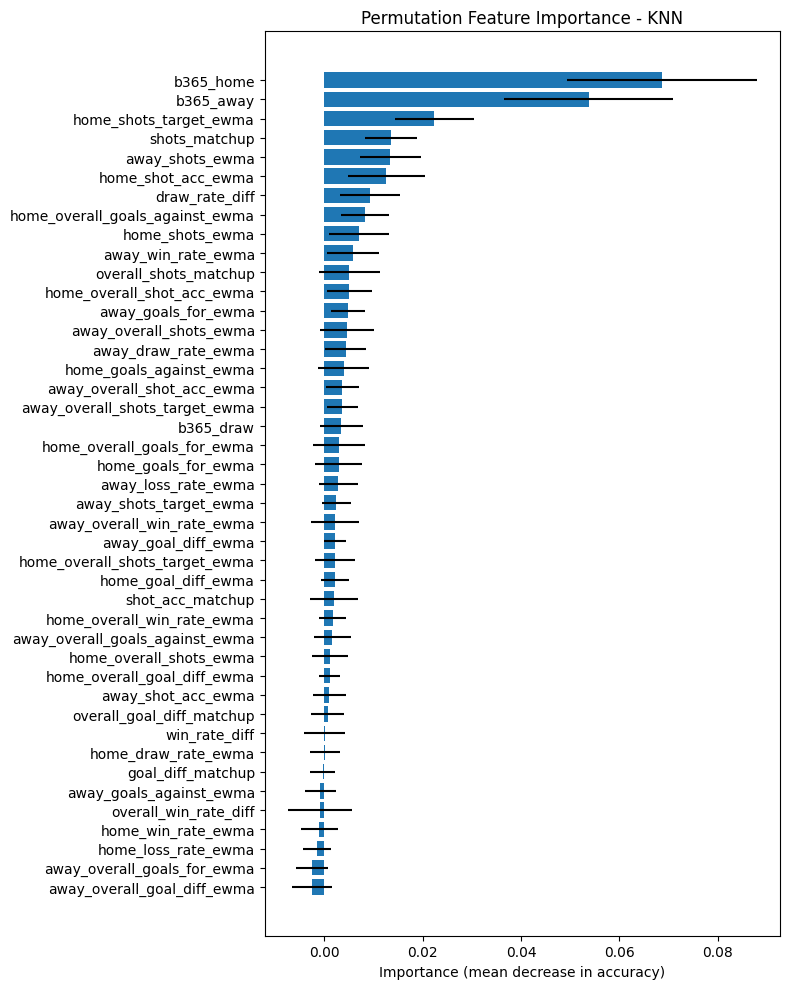

In [44]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

result = permutation_importance(
    model, X_test, y_test, n_repeats=100, random_state=RANDOM_STATE
)

# Create a DataFrame with mean and std
importances = pd.DataFrame({
    "mean": result.importances_mean,
    "std": result.importances_std
}, index=X_train.columns)

# Sort by mean importance
importances = importances.sort_values("mean", ascending=True)

# Plot with error bars
plt.figure(figsize=(8, 10))
plt.barh(importances.index, importances["mean"], xerr=importances["std"], align="center")
plt.title("Permutation Feature Importance - KNN")
plt.xlabel("Importance (mean decrease in accuracy)")
plt.tight_layout()
plt.show()


In [40]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import graphviz


In [41]:
p_bb_train_c = model.predict(X_train)
p_bb_test_c  = model.predict(X_test)


surrogate_c = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate_c.fit(X_train, p_bb_train_c)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [42]:
y_pred_sur  =surrogate_c.predict(X_test)
print("Comparação com os Dados do XGBoost")
print(classification_report(y_pred, y_pred_sur))

Comparação com os Dados do XGBoost
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       136
           1       0.47      0.71      0.57        49
           2       0.90      0.90      0.90       194

    accuracy                           0.84       379
   macro avg       0.78      0.80      0.78       379
weighted avg       0.87      0.84      0.85       379



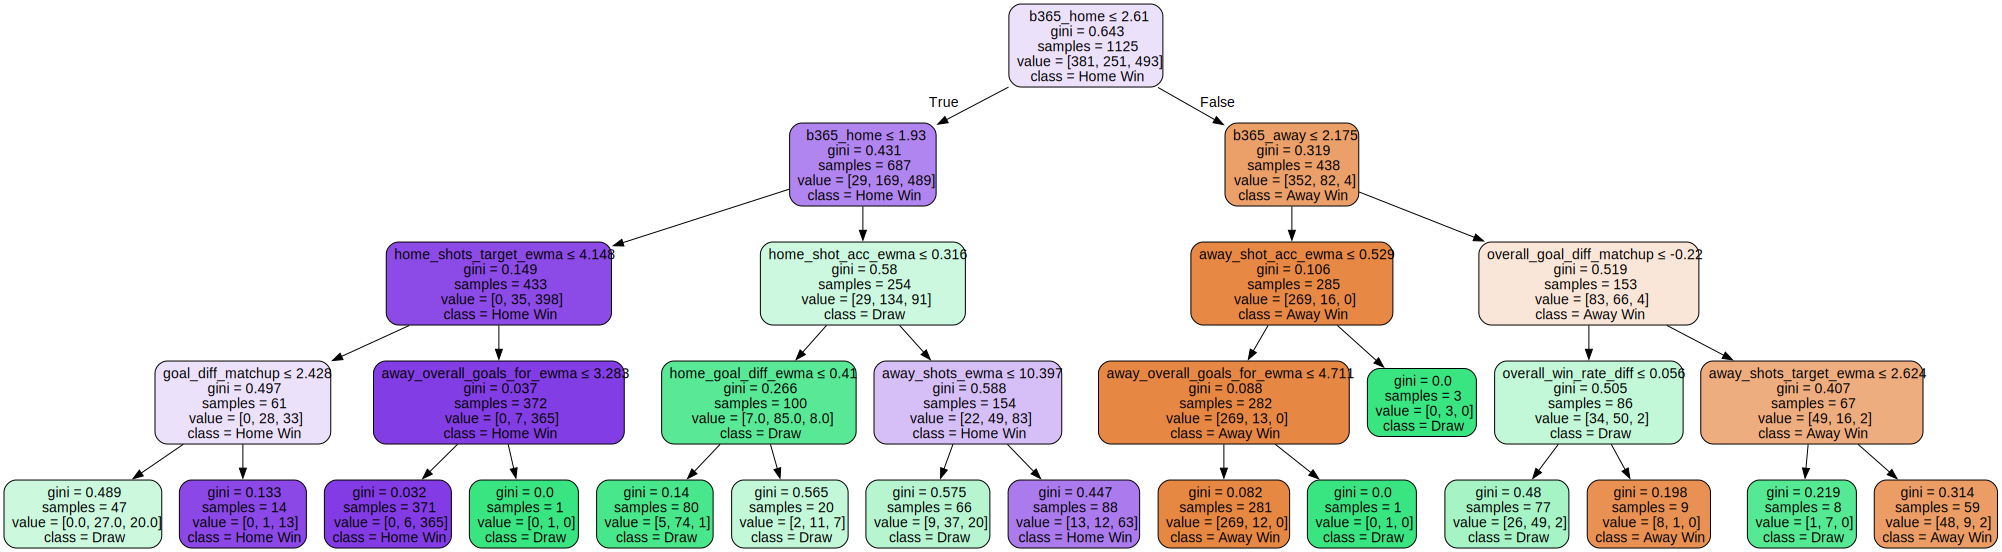

In [43]:
class_labels = ["Away Win", "Draw", "Home Win"]  # Adjust to your use

dot_data = export_graphviz(
    surrogate_c,
    out_file=None,
    feature_names=X_train.columns,
    class_names=class_labels,            # <--- add this line
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5
)

graph = graphviz.Source(dot_data)
graph.render("surrogate_tree_classifier", format="png", cleanup=True)
graph  # (shows in notebook)


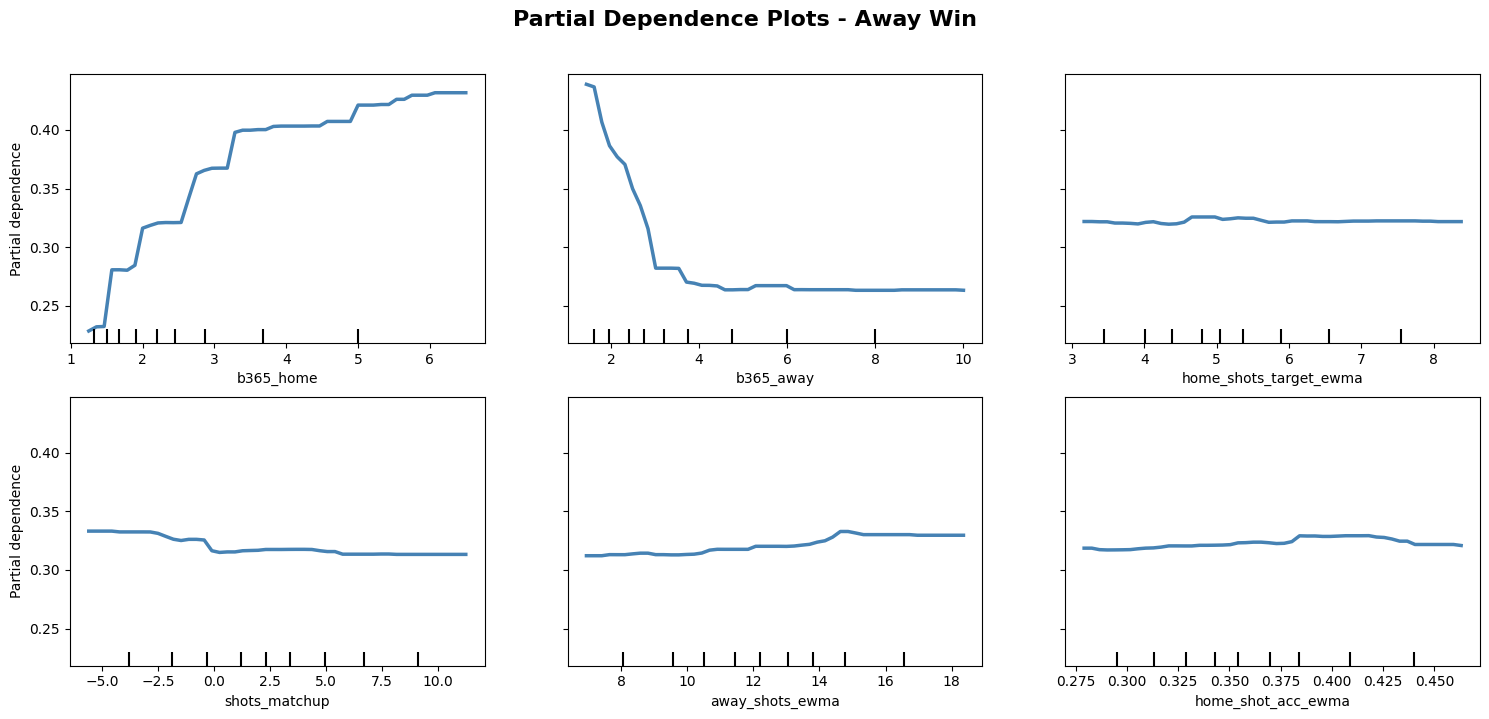

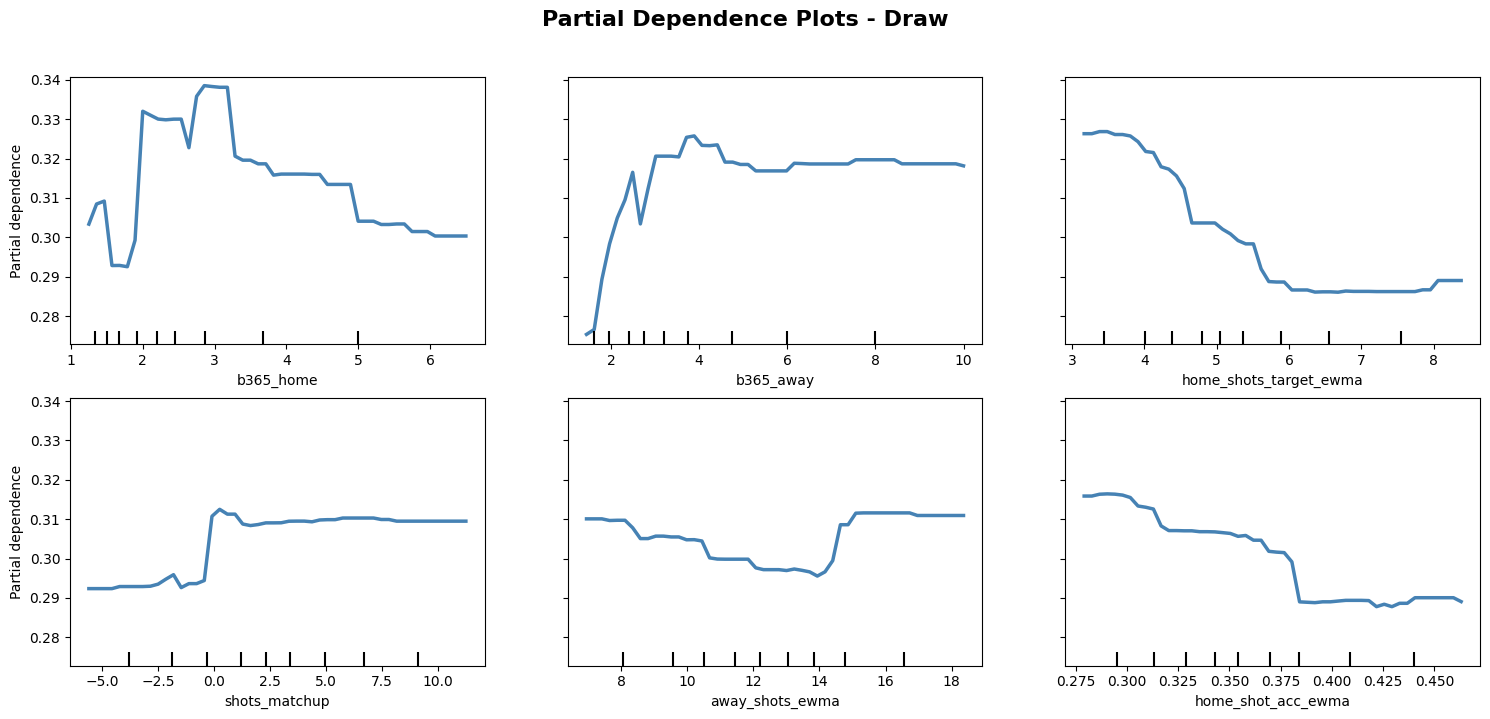

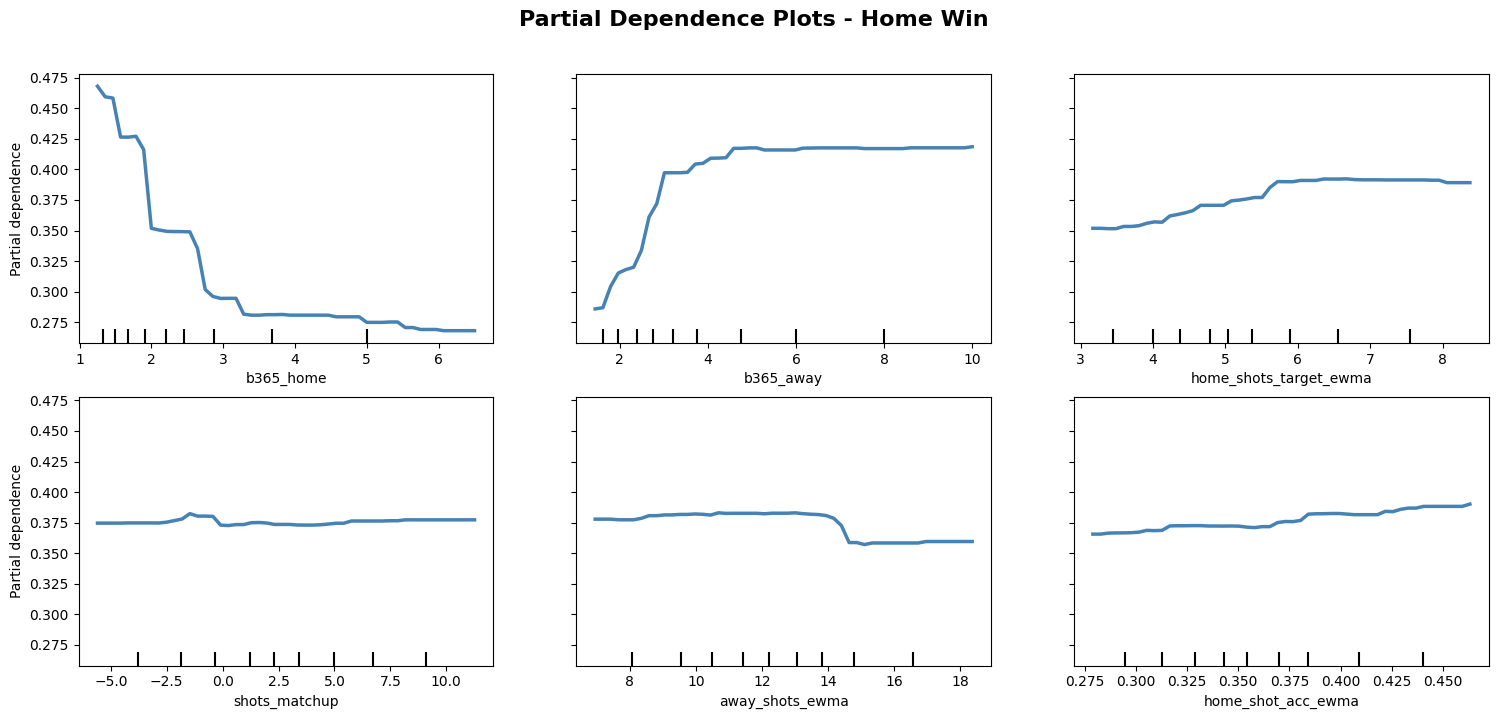

In [53]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

n = 6  # número de features mais importantes

top_features = importances.sort_values("mean", ascending=False).head(n).index.tolist()                                   # extrai só os nomes das features

target_names=['Away Win', 'Draw', 'Home Win']

for i, name in enumerate(target_names):

    fig, ax = plt.subplots(figsize=(15, 7))
    disp = PartialDependenceDisplay.from_estimator(
        model, 
        X_test, 
        top_features,
        target=i,
        grid_resolution=50,
        n_cols=3,
        ax=ax,
        kind='average',  # ou 'both' para ver ICE curves também
        line_kw={"color": "steelblue", "linewidth": 2.5}
    )
    plt.suptitle(f"Partial Dependence Plots - {name}", 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

Analyzing 15 unique feature interactions: [('b365_home', 'b365_away'), ('b365_home', 'home_shots_target_ewma'), ('b365_home', 'shots_matchup'), ('b365_home', 'away_shots_ewma'), ('b365_home', 'home_shot_acc_ewma'), ('b365_away', 'home_shots_target_ewma'), ('b365_away', 'shots_matchup'), ('b365_away', 'away_shots_ewma'), ('b365_away', 'home_shot_acc_ewma'), ('home_shots_target_ewma', 'shots_matchup'), ('home_shots_target_ewma', 'away_shots_ewma'), ('home_shots_target_ewma', 'home_shot_acc_ewma'), ('shots_matchup', 'away_shots_ewma'), ('shots_matchup', 'home_shot_acc_ewma'), ('away_shots_ewma', 'home_shot_acc_ewma')]



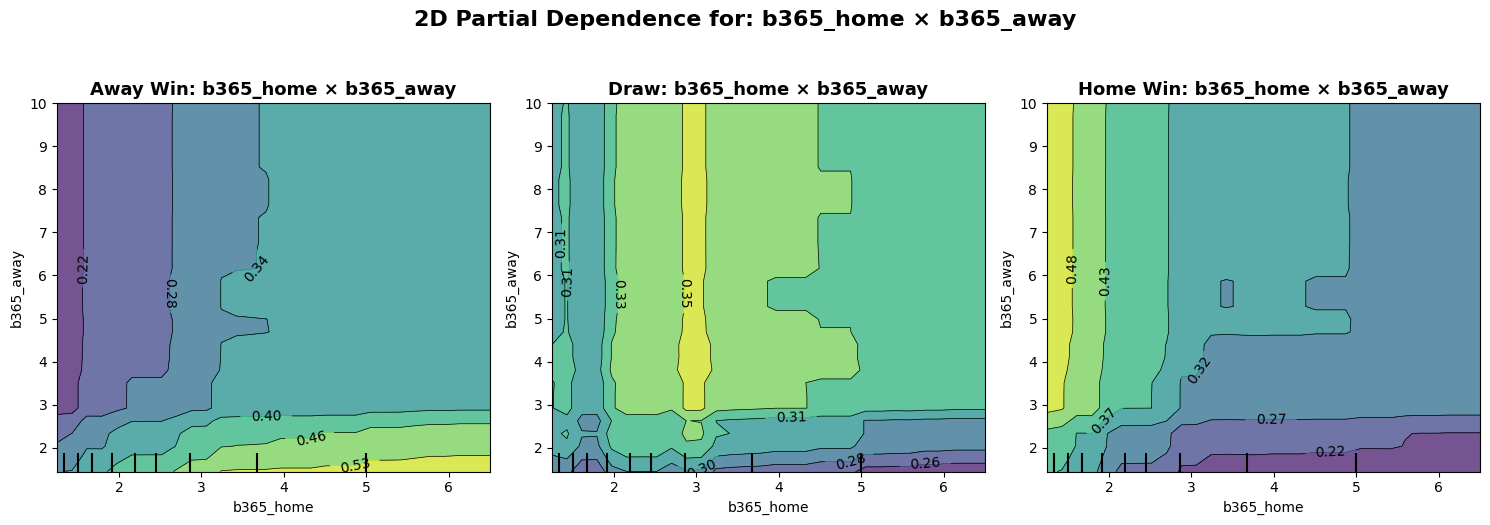

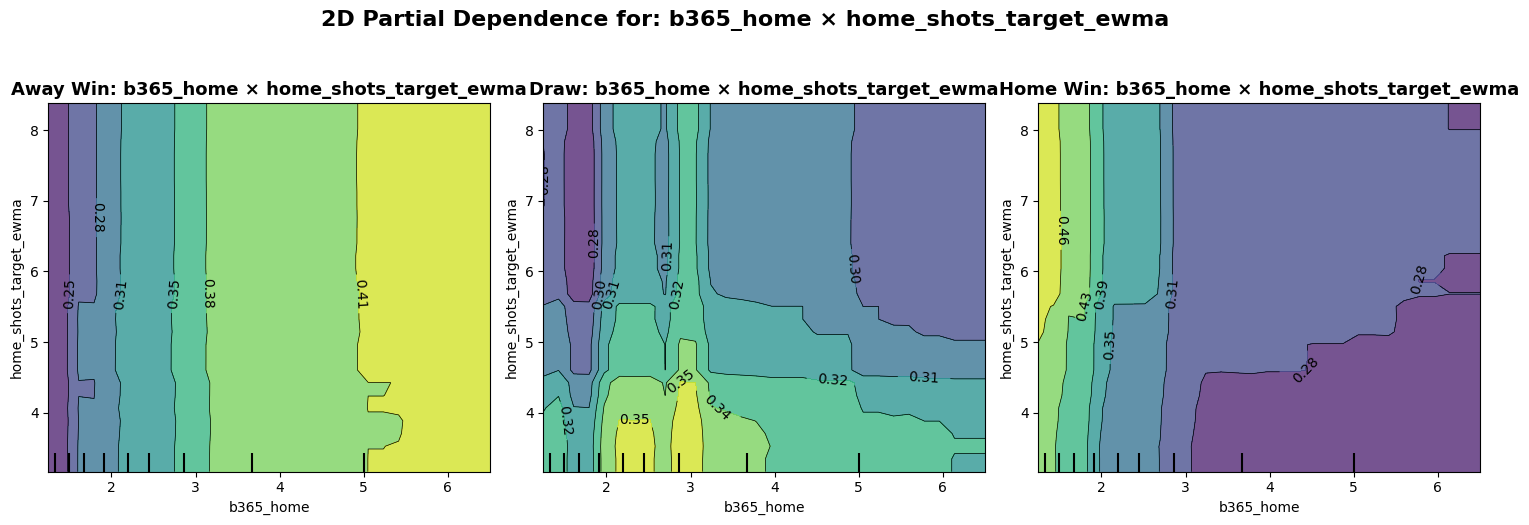

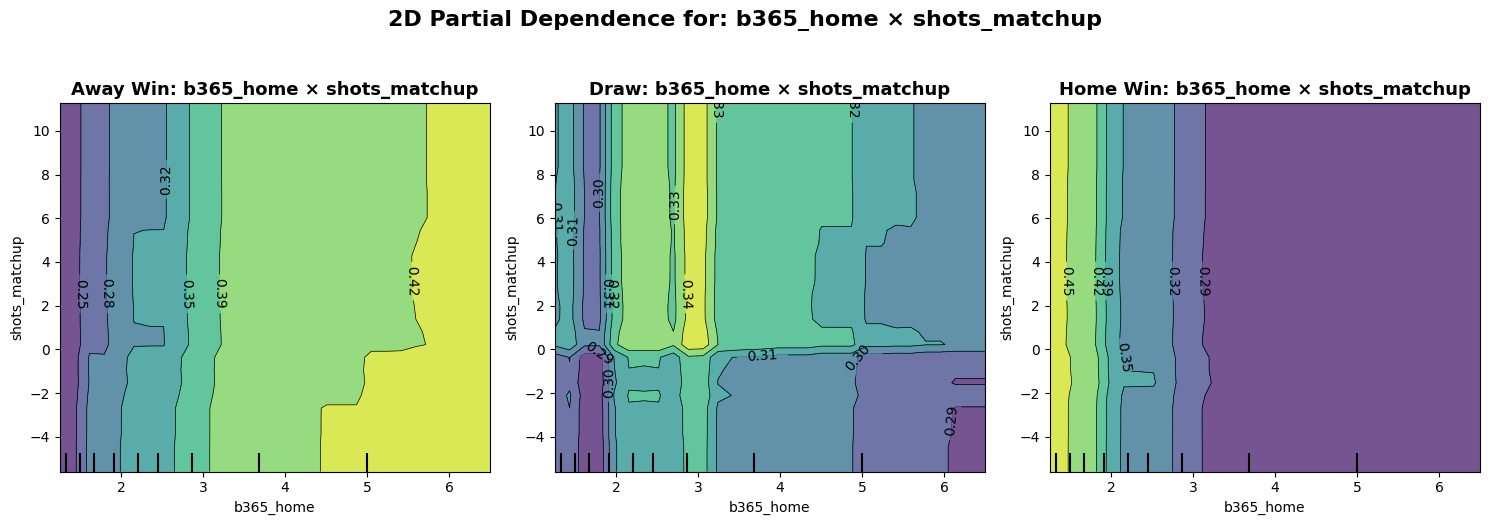

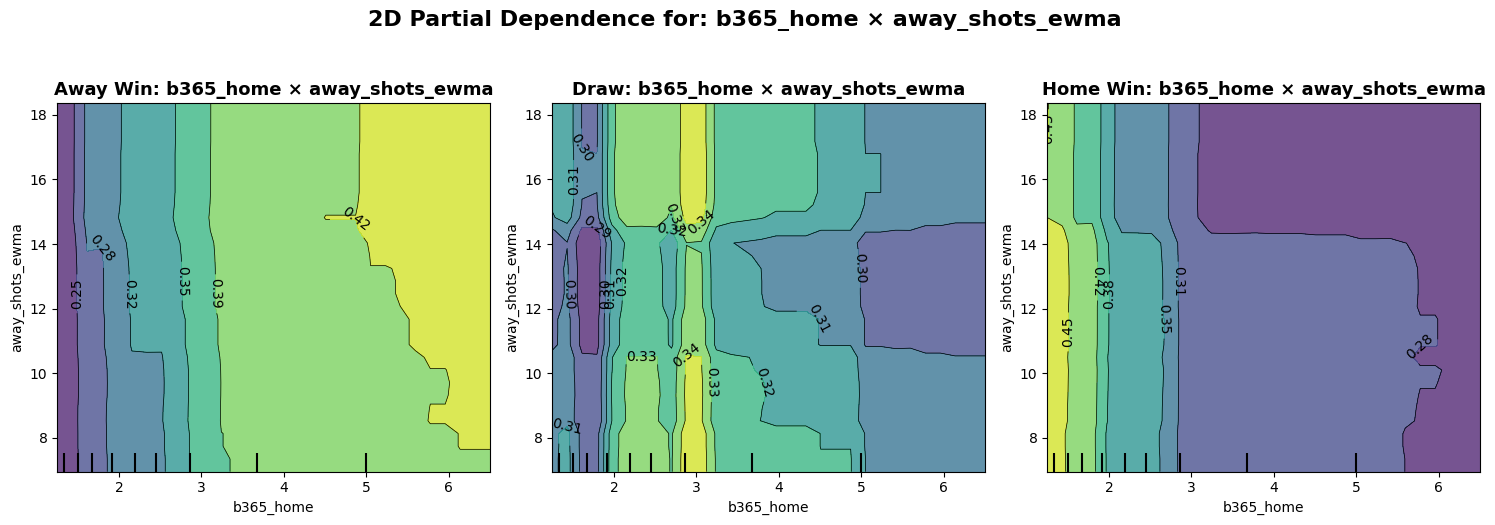

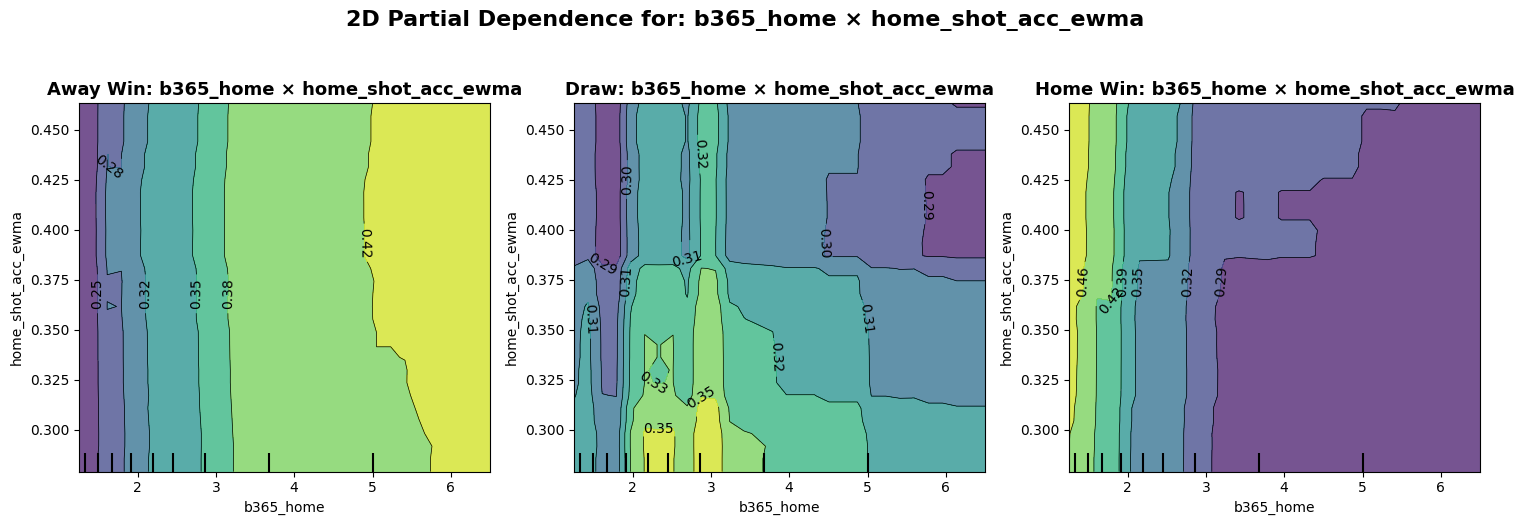

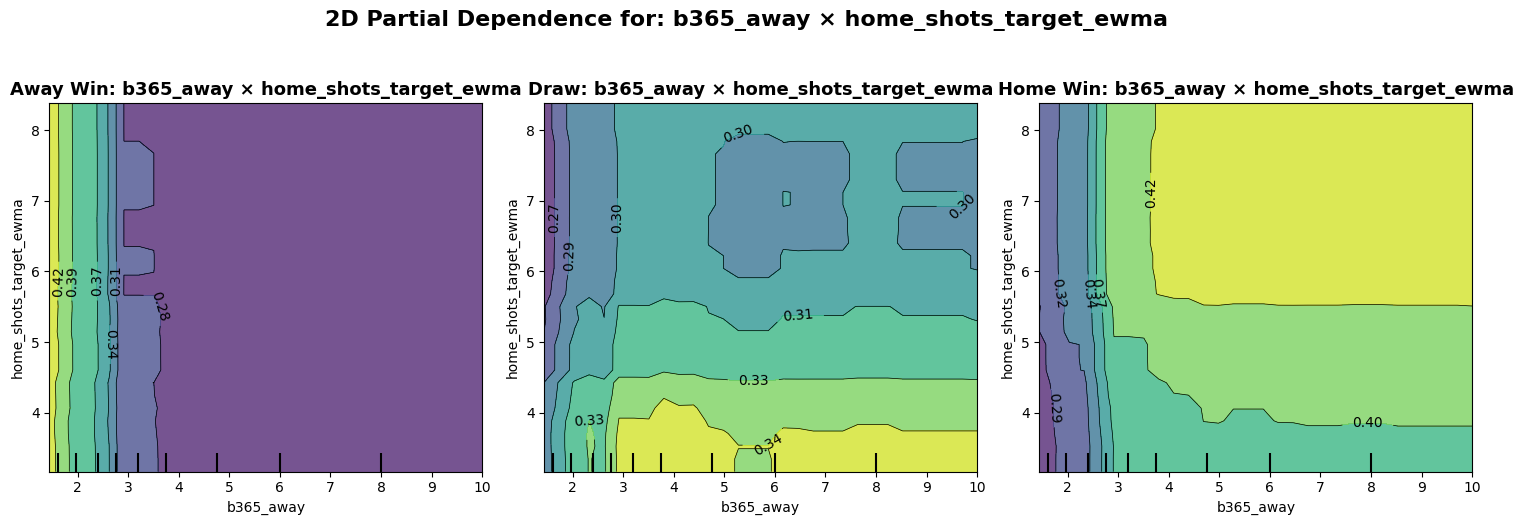

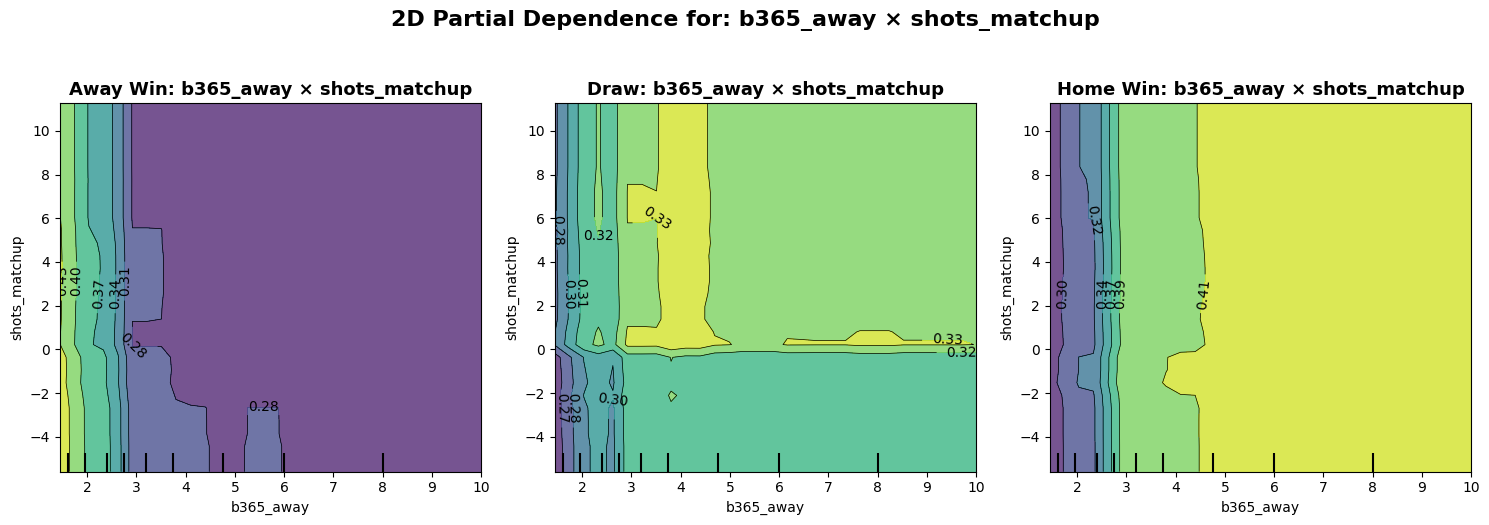

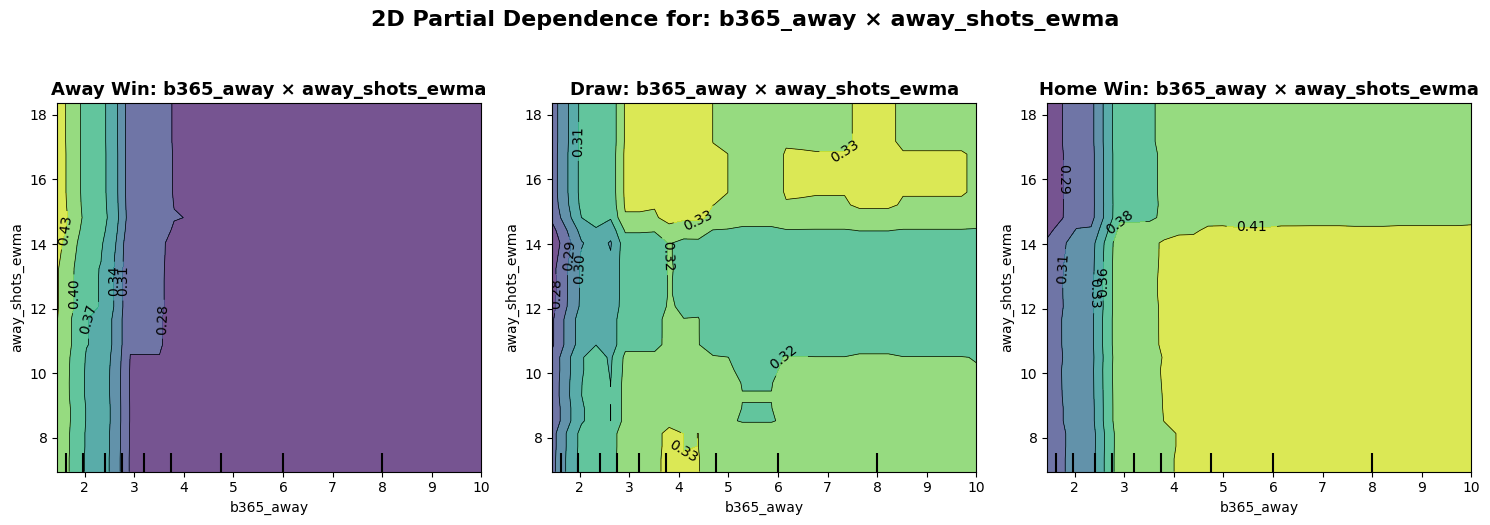

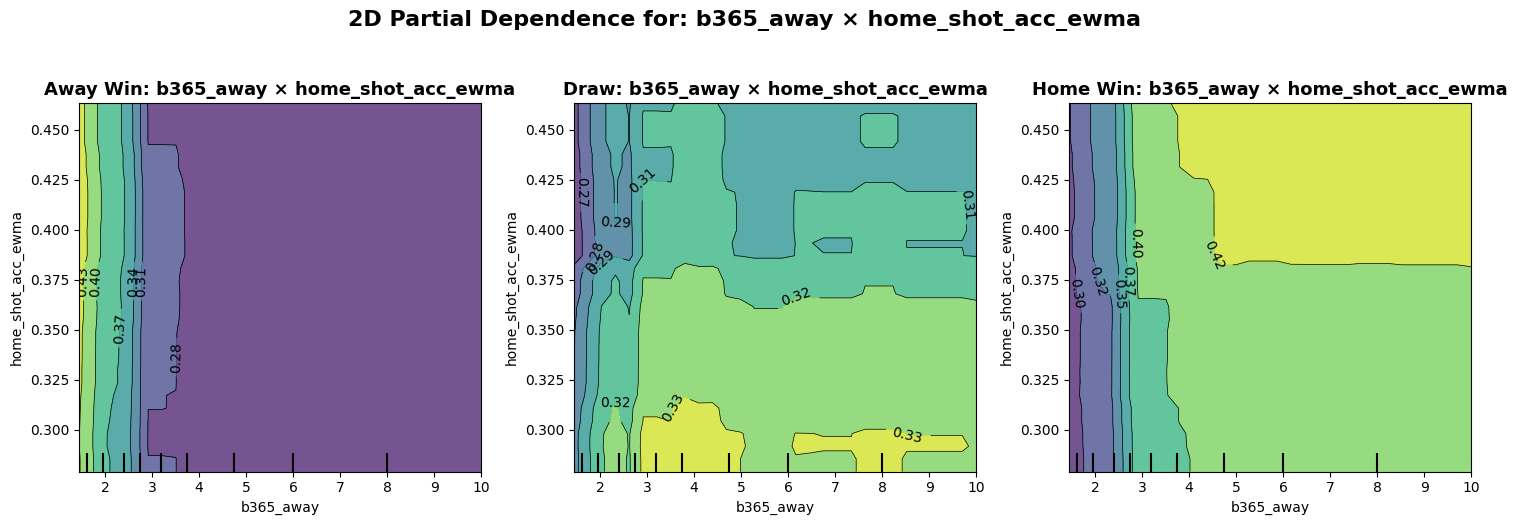

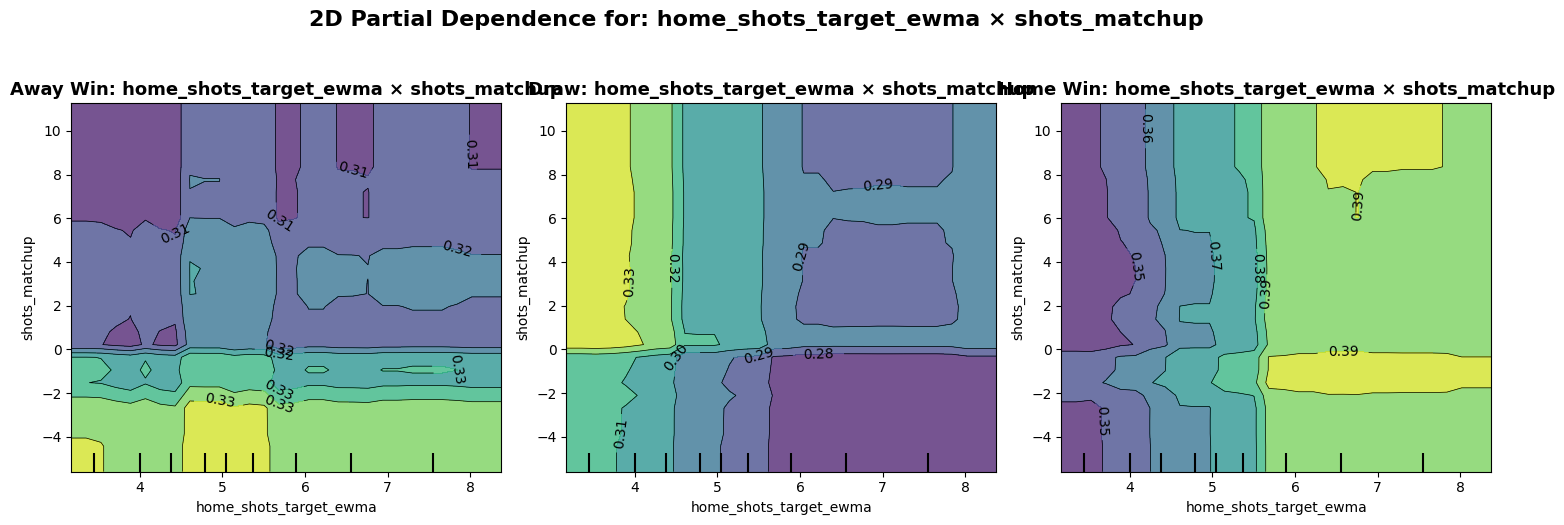

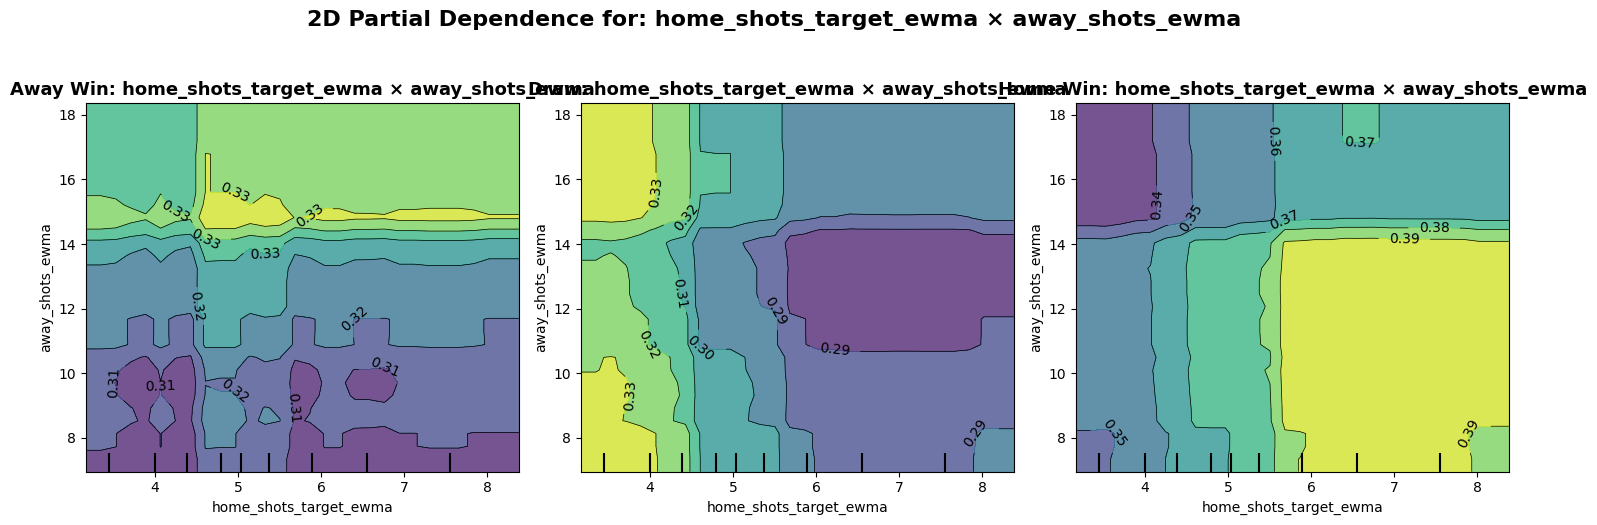

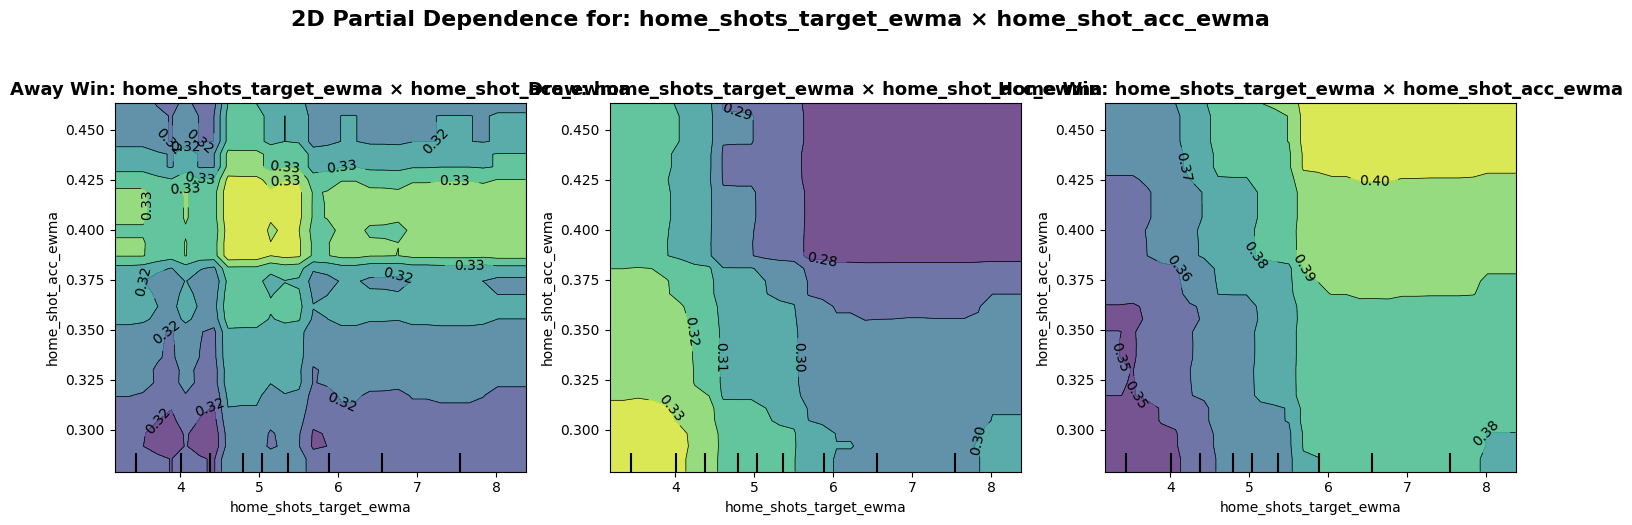

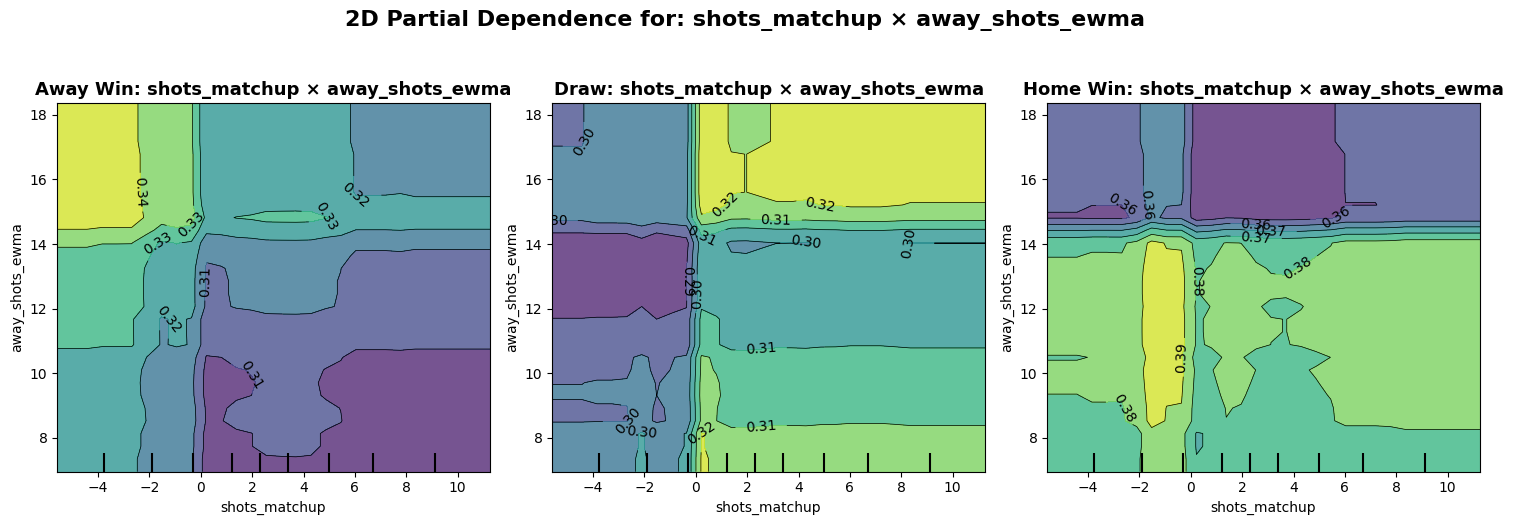

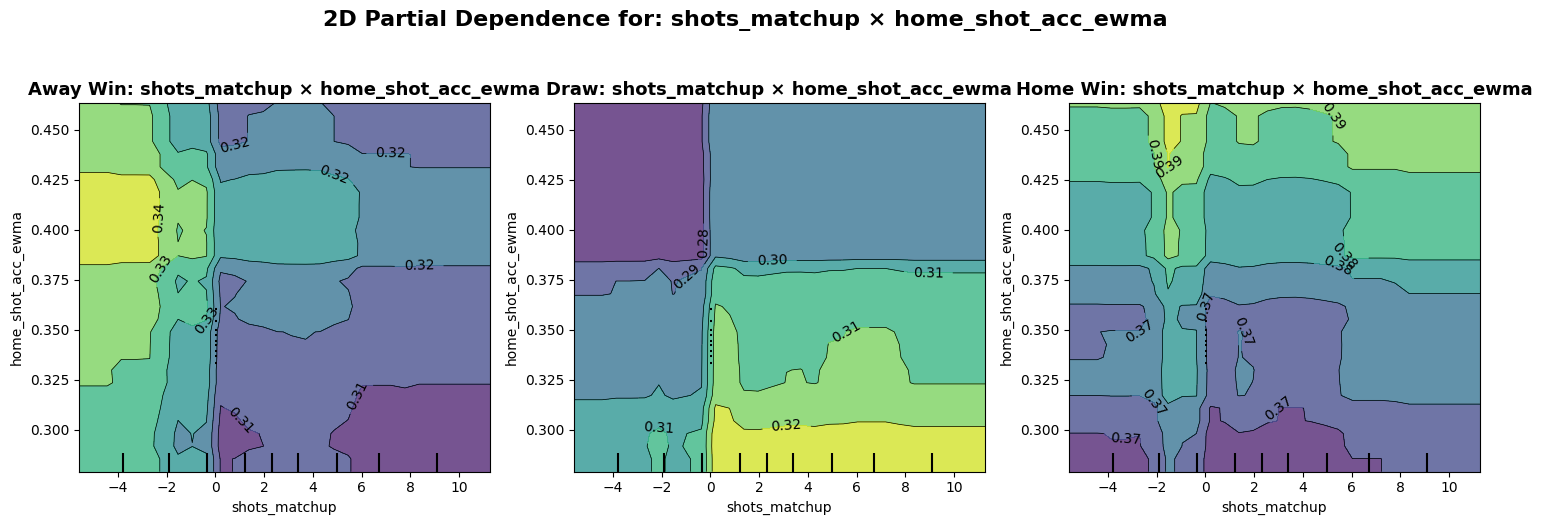

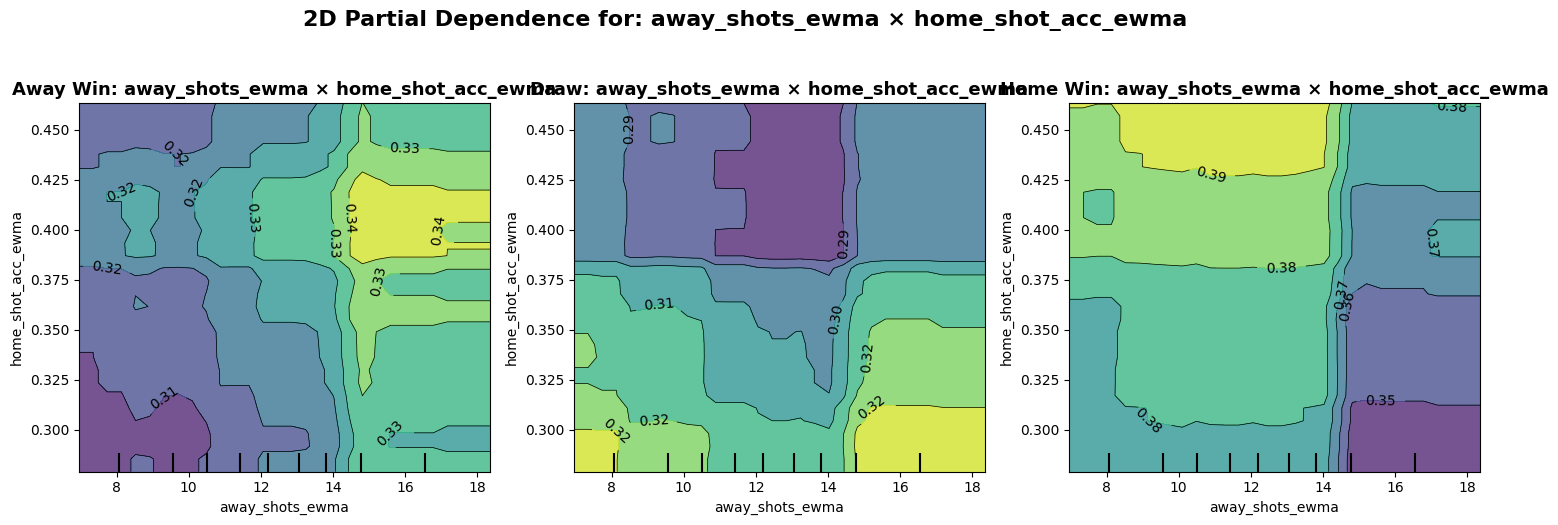

In [55]:
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

feature_pairs = list(combinations(top_features, 2))
print(f"Analyzing {len(feature_pairs)} unique feature interactions: {feature_pairs}\n")

n_pairs = len(feature_pairs)
n_classes = len(target_names)

for idx, (var1, var2) in enumerate(feature_pairs):
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * 5, 5), squeeze=False)
    for i, name in enumerate(target_names):
        disp = PartialDependenceDisplay.from_estimator(
            model,
            X_test,
            [(var1, var2)],
            target=i,
            grid_resolution=30,
            ax=axes[0, i],  # axes is 2D array
            kind='average'
        )
        axes[0, i].set_title(f"{name}: {var1} × {var2}", fontsize=13, fontweight='bold')
    plt.suptitle(f"2D Partial Dependence for: {var1} × {var2}",
                 fontsize=16, fontweight='bold', y=1.04)
    plt.tight_layout()
    plt.show()


### Local